# Assigning lipids to leaflets

For many analyses, such as calculating the area per lipid or domain registration, we first need to know which leaflet each lipid is in at each frame.

Below, we will assign lipids to either the upper leaflet, lower leaflet, or the midplane in an equimolar DPPC/DOPC/Cholesterol mixture. The membrane consists of 12000 lipids in total and was simulated using the [MARTINI](http://cgmartini.nl/) force field. The simulations were performed by [Smith et al.](https://www.biorxiv.org/content/10.1101/2021.05.24.445501v3)


In [4]:
import pickle  # this library is used for saving the analysis objects to file

import numpy as np
import MDAnalysis as mda

from lipyphilic.lib.assign_leaflets import AssignLeaflets, AssignCurvedLeaflets


We first need to load our topology and trajectory using MDAnalysis:

In [5]:
u = mda.Universe("../datafiles/dppc-dopc-chol.tpr", "../datafiles/dppc-dopc-chol.xtc")

The class `lipyphilic.lib.assign_leaflets.AssignLeaflets` can be used to assign each lipid to a leaflet based on the distance in *z*  to the midpoint of the bilayer. 

In [6]:
leaflets = AssignLeaflets(
    universe=u,
    lipid_sel="name GL1 GL2 ROH"
)

The selection "*name GL1 GL2 ROH*" will use the glycerol backbone of the phospholipids and the hydroxyl headgroup of cholesterol to calculate the midpoint of the bilayer. Phospholipids with the center of mass of the GL1 and GL2 beads above the midpoint will be assigned to the upper leaflet, along with cholesterol molecules with their ROH bead above the midpoint.

We then select which frames of the trajectory to analyse (`None` will use every frame) and choose to display a progress bar (`verbose=True`):
  

In [7]:
leaflets.run(
    start=None,
    stop=None,
    step=None,
    verbose=True
)

  0%|          | 0/51 [00:00<?, ?it/s]

### Accessing the results

The results are then available in the `leaflets.leaflets` attribute as a `numpy.ndarray`. As mentioned above, each row corresponds to an individual lipid and each column to an individual frame.

In [76]:
# There are 12000 lipids in total 
leaflets.leaflets.shape

(12000, 51)

Lipids in the upper leaflet are assigned a value of one, and those in the lower leaflet a value of -1. Let's take a look at the first lipid:

In [77]:
first_lipid = leaflets.leaflets[0]
first_lipid

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int8)

We see that this lipid is in the upper leaflet at each one of the 51 frames in the trajectory.

### How do we know which row corresponds to which lipid?

The lipids in the results array are ordered by their residue index, which is defined by MDAnlysis.

To know which lipid each row corresponds to, we can create a residue group based on the `lipid_sel` we used to assign leaflets:

In [78]:
membrane = u.select_atoms("name GL1 GL2 ROH").residues  # the selection is the same passed to AssignLeaflets

In [79]:
# As expected, there are 12000 lipids in the ResidueGroup
membrane.n_residues

12000

In [80]:
# We can check which residue this is
membrane[0]

<Residue CHOL, 1>

With this ResidueGroup, we can, for example, retrieve the leaflet information of cholesterol only.

For this, we will use a *boolean mask*, which is an array of `True` and `False` values.

In [81]:
# Create the boolean mask
cholesterol_mask = membrane.resnames == "CHOL"

In [82]:
# The array is a one-dimensional array of shape (12000)
cholesterol_mask

array([ True,  True,  True, ..., False, False, False])

In [83]:
# Use the mask to select only cholesterol from the results array
# The are 4000 cholesterol molecules in the mixture
leaflets.leaflets[cholesterol_mask].shape

(4000, 51)

In [84]:
leaflets.leaflets[cholesterol_mask]

array([[ 1,  1,  1, ...,  1,  1,  1],
       [-1, -1, -1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int8)

`AssignLeaflets` has a `filter_leaflets` helper function that can be used to selected a subset of lipids or frames.

This takes an atom selection that will be used to filter lipids, as well as `start`, `stop`, and `step` keywords to select a subset of frames:

In [85]:
# There are 8000 phospholipids in total, 6 frames if we used only every 10th one.
leaflets.filter_leaflets(
    lipid_sel="not resname CHOL",  # select DPPC and DOPC only
    start=None,
    stop=None,
    step=10
).shape

(8000, 6)

### Storing the results
There are a couple of ways of storing the results from the analysis.

1. You can persist the `AssignLeaflets` object using joblib (or pickle)

In [8]:
# store the object
with open("../results/leaflets.pkl", 'wb') as f:
    pickle.dump(leaflets, f)
    

In [23]:
# load for later usage
with open("../results/leaflets.pkl", 'rb') as f:
    leaflets = pickle.load(f)
    

2. You can extract the results and store the numpy array

In [9]:
# store the results array only
np.save("../results/leaflets.npy", leaflets.leaflets)

In [10]:
# load for later usage
leaflets_data = np.load("../results/leaflets.npy")

# Allowing lipids in the midplane

The above example will assign every lipid (including sterols) to either the upper or lower leaflet. To allow cholesterol to be in the midplane, we can provide a `midplane_sel` `midplane_cutoff` to `AssignLeaflets`:

In [86]:
leaflets = AssignLeaflets(
    universe=u,
    lipid_sel="name GL1 GL2 ROH",
    midplane_sel="resname CHOL and name ROH C2",
    midplane_cutoff=12.0
)
  

Based on the above selection, a cholesterol molecule that has *both* its *ROH* and *C2* atoms within *12* Å the membrane midpoint will be assigned to the midplane.

Lipids in the midplane are assigned a value of 0 in the results array.


In [87]:
leaflets.run(
    start=None,
    stop=None,
    step=None,
    verbose=True
)

  0%|          | 0/51 [00:00<?, ?it/s]

Below we see that the 2nd lipid is in the midplane at the final frame:

In [88]:
leaflets.leaflets

array([[ 1,  1,  1, ...,  1,  1,  1],
       [-1, -1, -1, ...,  1,  1,  0],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int8)

In [89]:
# Check the leaflet ID of the second lipid at the final frame
leaflets.leaflets[1, -1]

0

# Changing the resolution of the membrane grid

The first two examples compute a global membrane midpoint based on all the atoms of the lipids in the membrane. Lipids are then assigned a leaflet based on their distance in $z$ to this midpoint.

This is okay for planar bilayers, but can lead to incorrect leaflet classification in membranes with undulations. If your bilayer has undulations,
`AssignLeaflets` can account for this by creating a grid in $xy$ of your membrane, calculating the local membrane midpoint in each patch,
then assigning leaflet membership based on distance in $z$ to the local membrane
midpoint.

This resolution of the two-dimensional grid is set through use of the `n_bins` keyword.

### For this example, we will use a model of the neuronal plasma memrbane from the study by [Ingólfsson et al. (2017)](https://www.cell.com/biophysj/fulltext/S0006-3495(17)31132-3).


In [ ]:
u = mda.Universe("../datafiles/LIM25_neuronal_plasma_membrane.gro")

This is a complex mixture that has 58 different lipid species.

Using the poweful selection language of MDAnalysis, it is simple to select all lipid in the membrane.

In [91]:
membrane = u.select_atoms("name GL1 GL2 AM1 AM2 ROH")

print(np.unique(membrane.resnames))

['CHOL' 'DBCE' 'DBG1' 'DBG3' 'DBGS' 'DOPC' 'DPCE' 'DPG1' 'DPG3' 'DPGS'
 'DPPC' 'DPPS' 'DPSM' 'I0PC' 'I0PE' 'OAPE' 'OIPC' 'OIPE' 'OUPC' 'OUPE'
 'OUPS' 'P0PC' 'P0PE' 'PADG' 'PAI1' 'PAI6' 'PAI7' 'PAPA' 'PAPC' 'PAPE'
 'PAPI' 'PAPS' 'PBSM' 'PIPI' 'PNCE' 'PNG1' 'PNG3' 'PNGS' 'PNSM' 'POCE'
 'PODG' 'POG1' 'POG3' 'POGS' 'POI1' 'POI6' 'POI7' 'POPA' 'POPC' 'POPE'
 'POPI' 'POPS' 'POSM' 'PUPC' 'PUPE' 'PUPI' 'PUPS' 'PWPC']


As expected, we see there are 58 different lipid species in this membrane

In [92]:
np.unique(membrane.resnames).size

58

Now lets assign these lipids to leaflets:

In [93]:
leaflets = AssignLeaflets(
    universe=u,
    lipid_sel="name GL1 GL2 AM1 AM2 ROH",
    midplane_sel="name ROH",
    midplane_cutoff=8.0,
    n_bins=10
)

In this example, the membrane will be split into a *10 x 10* grid and a lipid assigned a leaflet based on the distance to the *midpoint of the patch the lipid is in*.

In [94]:
leaflets.run(
    start=None,
    stop=None,
    step=None,
    verbose=True
)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/paul/git-repos/mdanalysis/package/MDAnalysis/coordinates/base.py:887: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


In [95]:
# There are over 19000 lipids and a single frame
leaflets.leaflets.shape

(19447, 1)

Below we see lipids assigned to the upper leaflet (blue), lower leaflet (red), or the midplane (yellow):

<div>
<center>    
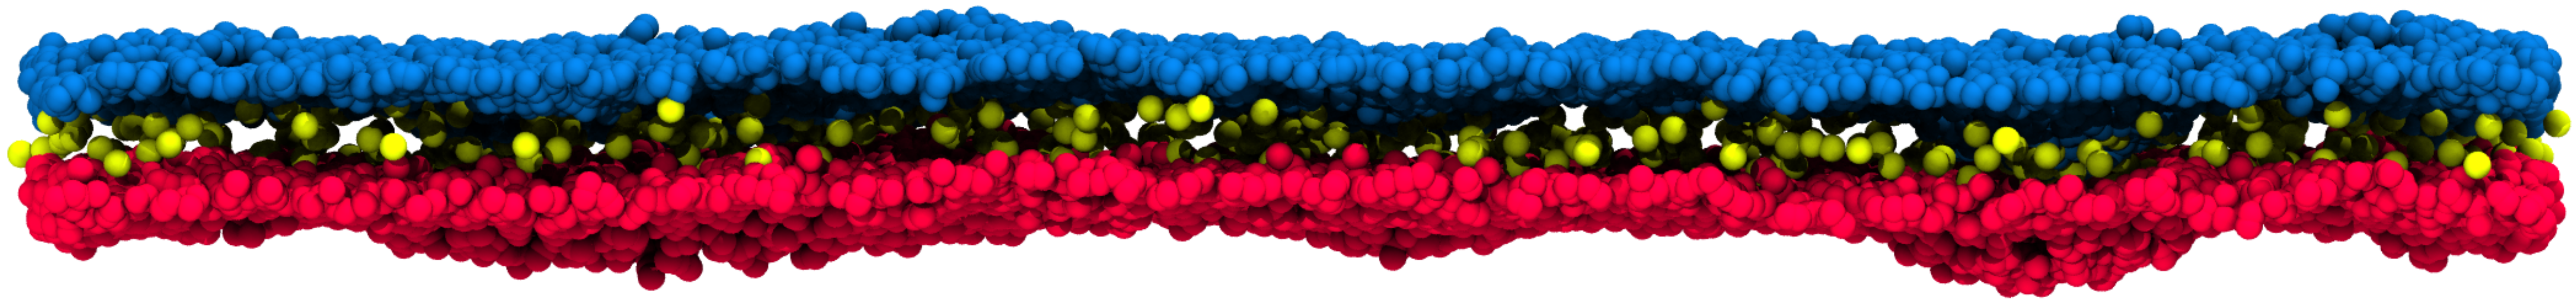
</center>
</div>

`AssignLeaflets` accurately captures the small undulations in the shape of the membrane when assigning lipids to leaflets.


# Assigning leaflets in membranes with high curvature

If your membrane is a vesicle or bilayer with *very* large undulations, such as in a [buckled membrane](https://aip.scitation.org/doi/pdf/10.1063/1.4808077), `lipyphilic.lib.assign_leaflets.AssignLeaflets` will assign lipids to the wrong leaflet

The class `lipyphilic.lib.assign_leaflets.AssignCurvedLeaflets` can be used in these scenaries to assign each lipid to a leaflet using [MDAnalysis' Leaflet Finder](https://docs.mdanalysis.org/1.0.0/documentation_pages/analysis/leaflet.html).

Lipids may still be assigned to the upper/outer leaflet (indicated by 1), the lower/inner leaflet (-1) or the membrane midplane (0):


In [96]:
leaflets = AssignCurvedLeaflets(
    universe=u,
    lipid_sel="name GL1 GL2 AM1 AM2 ROH",
    lf_cutoff=15,
    midplane_sel="name ROH",
    midplane_cutoff=12
)

Usuage of `AssignCurvedLeaflets` is very similar to that of `AssignLeaflets`.

There are however, a few differences:
- there is no `n_bins` keyword
- `lf_cutoff` is the cutoff value used by the [MDAnalysis' Leaflet Finder](https://docs.mdanalysis.org/1.0.0/documentation_pages/analysis/leaflet.html)
- Moleules in `midplane_sel` will be assigned to the midplane if they are more than `midplane_cutoff` from **both** leaflets.


In [97]:
leaflets.run(
    start=None,
    stop=None,
    step=None,
    verbose=True
)

  0%|          | 0/1 [00:00<?, ?it/s]

At the first frame, [MDAnalysis' Leaflet Finder](https://docs.mdanalysis.org/1.0.0/documentation_pages/analysis/leaflet.html) is used to assign all molecules that are not allowed in the midplane to either the upper or lower leaflet.

Then, at each frame, molecules that may be in the midplane are assigned leaflets.


### Accessing the results

The results are accessed in exactly the same way as with `AssignLeaflets`:

In [98]:
# There are over 19000 lipids and a single frame
leaflets.leaflets.shape

(19447, 1)

In [99]:
leaflets.leaflets

array([[-1],
       [-1],
       [-1],
       ...,
       [ 1],
       [ 1],
       [ 1]], dtype=int8)